# <center>Empirical Analysis of Price Impact Based on Stochastic Liquidity

## <center> Yuqian Li

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings

# Suppress all FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

__load data into dictionary {str:dataframe}__

In [3]:
import os
import tarfile
from collections import defaultdict

# Path to the directory containing all the tar.gz files
data_dir = '/Users/liyuqian/Desktop/2024Fall/Capstone/compress_out'

# Create a dictionary to hold DataFrames
dfs_ticker_date = {}
dfs_ticker = {}
names = defaultdict(list)

# Check if the data directory exists
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"The directory {data_dir} does not exist.")

# Function to recursively search for any files in nested directories
def find_all_files(start_path):
    all_files = []
    for root, dirs, files in os.walk(start_path):
        for file in files:
            all_files.append(os.path.join(root, file))
    return all_files

# Loop through each tar.gz file in the directory
for filename in os.listdir(data_dir):
    if filename.endswith('.tar.gz'):
        filepath = os.path.join(data_dir, filename)
        
        # Extract the tar.gz file
        with tarfile.open(filepath, 'r:gz') as tar:
            extracted_folder = filename.replace('.tar.gz', '')  # Assuming folder name matches the tar file name
            extracted_path = os.path.join(data_dir, extracted_folder)

            # Ensure the directory is created during extraction
            if not os.path.exists(extracted_path):
                os.makedirs(extracted_path)
            
            #print(f"Extracting {filename} to {extracted_path}")
            tar.extractall(path=extracted_path)
            
            # Recursively find all files in the extracted directory
            all_files = find_all_files(extracted_path)
            
            # Print the found files for debugging
            if all_files:
                #print(f"Found {len(all_files)} files in {extracted_folder}:")
                for file in all_files:
                    #print(f"  - {file}")  # Print all files found
                    
                    # Load any file that contains 'bars' in its name
                    name = os.path.basename(file)
                    if 'bars' in name:  # Looks for "bars" in the filename
                        try:
                            temp = name[5:]
                            ticker, date = temp.split('.')
                            df = pd.read_csv(file, sep='\s+')
                            df.insert(loc=0,column='ticker',value=ticker)
                            df.insert(loc=1,column='date',value=date)
                            dfs_ticker_date[temp] = df
                            if ticker in dfs_ticker:
                                dfs_ticker[ticker] = pd.concat([dfs_ticker[ticker],df],axis=0,ignore_index=True)
                            else:
                                dfs_ticker[ticker] = df
                            names[ticker].append(date)
                            #print(f'Loaded {os.path.basename(file)} into a DataFrame')
                        except Exception as e:
                            print(f"Error loading {file}: {e}")
            else:
                print(f"No files found in {extracted_folder}")
                
for ticker in dfs_ticker:
    dfs_ticker[ticker] = dfs_ticker[ticker].sort_values(by=['date','time'],ascending=[True,True],ignore_index=True)

No files found in BF


In [4]:
# Check the content of the dataframes dictionary
print(f"Total dataframes (ticker+date) loaded: {len(dfs_ticker_date)}")
print(f"Total dataframes (ticker) loaded: {len(dfs_ticker)}")

Total dataframes (ticker+date) loaded: 15138
Total dataframes (ticker) loaded: 261


In [5]:
ticker_lst = list(names.keys())
ticker_lst.remove('SR')
ticker_lst.remove('FHN')
ticker_lst.remove('AXS')
ticker_lst.remove('ALL')

In [6]:
def get_ticker_df(dic, ticker):
    return dic[ticker]

In [7]:
def pre_dropna(df):
    df_filter = df[(df['time']>='09:30:00')&(df['time']<='15:59:00')]
    df_filter = df_filter.dropna(subset=['trade_volume','trade_last','buy_vol','sell_vol'],ignore_index=True)
    return df_filter

In [8]:
def cal_ADV(df):
    '''ADV: average daily (sum by date) trade_volume'''
    
    ADV = df.groupby(by='date')['trade_volume'].sum().reset_index()['trade_volume'].mean()
    return ADV

In [9]:
def cal_sigma(df, annualized):
    """trade_last (15:59) daily log return std"""
    
    df_day_end = df[df['time']=='15:59:00']
    df_day_end.index = range(len(df_day_end))
    sigma = np.log(df_day_end['trade_last']).diff().std()
    
    return sigma * np.sqrt(252/len(df_day_end)) if annualized else sigma

In [10]:
def gen_elements_df(df):
    """generate 5-min bin data"""
    
    # assign number to denote for 5-min bin
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    df.set_index('datetime', inplace=True)
    df['5min_bin_number'] = df.index.floor('5min')
    
    # remove 5-min bins which have any minute missing
    df_5min = df.groupby(['5min_bin_number']).filter(lambda x: len(x) == 5)
    
    df_data = df_5min.groupby('5min_bin_number').agg(
        I = ('trade_last', lambda x: x.iloc[-1] - x.iloc[0]),
        trade_last = ('trade_last', lambda x: x.iloc[-1]),
        trade_vol_sum = ('trade_volume', np.sum),
        buy_vol_sum = ('buy_vol', np.sum),
        sell_vol_sum = ('sell_vol', np.sum),
        bid_size_mean = ('bid_size',np.mean),
        ask_size_mean = ('ask_size',np.mean)
    ).reset_index()
    
    """5-min time: key for intraday grouping"""
    df_data['time'] = pd.to_datetime(df_data['5min_bin_number']).dt.time 
    df_data['F'] = df_data['buy_vol_sum'] - df_data['sell_vol_sum']
    df_data['delta_I'] = df_data['I'].diff()
    df_data['delta_F'] = df_data['F'].diff()
    df_data['D'] = df_data['bid_size_mean'] + df_data['ask_size_mean']

    # v_t? ignore the 3rd model: reduced form model
    
    return df_data

In [11]:
def gen_X_by_model(df, sigma, ADV, model):
    """generate X1 and X2 in regression"""
    
    X1 = -df['I'] * 5/60/24/240  # 5-min-bin
    
    if model == 'OW':
        X2 = sigma * df['delta_F'] / ADV
    
    elif model == 'Propagator':
        X2 = sigma * df['delta_F'] * np.sqrt(np.abs(df['delta_F']) / ADV)       
        
    elif model == 'Reduced Form':
        X2 = sigma * df['delta_F'] / np.sqrt(ADV * df['v'])
    
    elif model == 'Depth':
        X2 = sigma * df['delta_F'] / df['D']
    
    else: print("Please input a model among 'OW', 'Propagator', 'Reduced Form', and 'Depth'.")
    
    X = pd.concat([X1[1:], X2[1:]], axis=1)
    X.columns = ['X1','X2']
    
    return X

# Part 1: basic OLS: plot y and y_pred, plot residual, examine normality and uncorrelation of residuals

In [12]:
def plot_pred(ticker, model, y, y_pred):

    plt.figure(figsize=(10, 6))
    plt.plot(y, label="Actual (y)", linestyle="-", marker="o")
    plt.plot(y_pred, label="Predicted (y_pred)", linestyle="--", marker="x")
    plt.title("Actual vs Predicted", fontsize=14)
    plt.xlabel("Index", fontsize=12)
    plt.ylabel("Scaled Value", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.5)
    plt.show()
    
    #plt.savefig(f'{ticker} {model} y and y_pred.png')

In [13]:
def conduct_OLS(ticker, df, sigma, ADV, model):
    
    import statsmodels.api as sm
    from sklearn.preprocessing import StandardScaler
    
    X = gen_X_by_model(df, sigma, ADV, model)
    y = df['delta_I'][1:]
    
    scaler = StandardScaler()
    X_stan = scaler.fit_transform(X)
    y_stan = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

    result = sm.OLS(y_stan, X_stan).fit()
    
    y_pred = result.predict(X_stan)
    residuals = result.resid
    
    stats = {
        "ticker":ticker,
        "model":model,
        "beta": result.params[0],
        'lambda': result.params[1],
        "R-squared": result.rsquared,
        "Adj. R-squared": result.rsquared_adj,
        "F-statistic": result.fvalue,
        "F-pvalue": result.f_pvalue,
        "MSE (Model)": result.mse_model,
        "MSE (Residual)": result.mse_resid,
        "RMSE (Residual)": np.sqrt(result.mse_resid),
        "AIC": result.aic,
        "BIC": result.bic
    }
    
    #plot_pred(ticker, model, y, y_pred, save) # plot or not #save or not
    
    return result.summary(), y_pred, residuals, stats

In [14]:
# input ticker and model, just for including them in the name of the graph
# time keyword for intraday time

def save_summary_as_image(ticker, model, summary, time=''): 
    
    summary_text = summary.as_text()
    
    plt.figure(figsize=(10, 6))
    plt.text(0, 1, summary_text, family='monospace', fontsize=10, verticalalignment='top')
    plt.axis('off')
    filename = f'{ticker} {model} {time} summary.png'
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.5, dpi=300)
    plt.close()

In [15]:
def save_dataframe_as_image(df, filename):
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off') 
    
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    plt.savefig(filename, bbox_inches='tight', dpi=300) 
    plt.close()

In [19]:
def plot_res(ticker, model, residuals):
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(residuals)), residuals)
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title(f'Residuals Scatter Plot of {ticker} {model}')
    plt.xlabel('Index')
    plt.ylabel('Residuals')
    plt.legend()
    plt.grid()
    #plt.savefig(f'{ticker} {model} residuals.png')
    plt.show()

In [20]:
def plot_qq(ticker, model, residuals):
    """QQ plot"""
    
    from scipy.stats import probplot

    plt.figure(figsize=(8, 6))
    probplot(residuals, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Residuals of {ticker} {model}")
    plt.grid()
    #plt.savefig(f'{ticker} {model} QQ plot of residuals.png')
    plt.show()

In [21]:
def ks_test(residuals):
    """Kolmogorov-Smirnov Test"""
    
    from scipy.stats import kstest, norm
    
    standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
    stat, p_value = kstest(standardized_residuals, 'norm')
    
    return stat, p_value

In [22]:
def plot_acf_pacf(ticker, model, residuals):

    import statsmodels.api as sm

    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    sm.graphics.tsa.plot_acf(residuals, lags=20, ax=ax[0])
    sm.graphics.tsa.plot_pacf(residuals, lags=20, ax=ax[1])
    ax[0].set_title(f'ACF of Residuals of {ticker} {model}')
    ax[1].set_title(f'PACF of Residuals of {ticker} {model}')
    plt.tight_layout()
    #plt.savefig(f'{ticker} {model} ACF and PACF of residuals.png')
    plt.show() 

In [23]:
def lb_test(residuals):
    """Box and Pierce joint test"""
    """Ljung and Box test: overall works better, especially for small sample case"""
    
    from statsmodels.stats.diagnostic import acorr_ljungbox
    
    lb_test_res = acorr_ljungbox(residuals, lags=[10], return_df=True, boxpierce=True)
    lb_stat, lb_pvalue, bp_stat, bp_pvalue = lb_test_res.iloc[0]
    
    return lb_stat, lb_pvalue, bp_stat, bp_pvalue

In [24]:
def adf_test(residuals):
    
    from statsmodels.tsa.stattools import adfuller
    
    adf_result = adfuller(residuals)
    adf_stat, adf_pvalue = adf_result[0], adf_result[1]
    
    return adf_stat, adf_pvalue

In [25]:
def main_for_single_ticker(dic, ticker, model):
    
    df = get_ticker_df(dic, ticker)
    
    df_filter = pre_dropna(df)
    
    ADV = cal_ADV(df_filter)
    sigma = cal_sigma(df_filter, True)
    df_data = gen_elements_df(df_filter)

    summary, y_pred, residuals, stats = conduct_OLS(ticker, df_data, sigma, ADV, model)
    
    #save_summary_as_image(ticker, model, summary)
    
    #plot_res(ticker, model, residuals)

    # examine normality
    #plot_qq(ticker, model, residuals)
    stats['ks_stat'], stats['ks_p_value'] = ks_test(residuals)

    # examine uncorrelation
    #plot_acf_pacf(ticker, model, residuals)
    stats['lb_stat'], stats['lb_pvalue'], stats['bp_stat'], stats['bp_pvalue'] = lb_test(residuals)
    stats['adf_stat'], stats['adf_pvalue'] = adf_test(residuals)
        
    return stats # dictionary

In [26]:
main_for_single_ticker(dfs_ticker, 'AAPL', 'OW')

{'ticker': 'AAPL',
 'model': 'OW',
 'beta': -0.6276129693755316,
 'lambda': 0.24929596492161718,
 'R-squared': 0.5796221468563211,
 'Adj. R-squared': 0.5794361800997877,
 'F-statistic': 3116.8051627136856,
 'F-pvalue': 0.0,
 'MSE (Model)': 1310.8154851155725,
 'MSE (Residual)': 0.420563819900213,
 'RMSE (Residual)': 0.6485089204476782,
 'AIC': 8920.080192843447,
 'BIC': 8932.914054382401,
 'ks_stat': 0.05313056309329678,
 'ks_p_value': 1.546174189722439e-11,
 'lb_stat': 34.83900842908637,
 'lb_pvalue': 0.0001330143282348939,
 'bp_stat': 34.79722897102016,
 'bp_pvalue': 0.00013521304333001419,
 'adf_stat': -51.5423070319689,
 'adf_pvalue': 0.0}

In [27]:
def main_for_multiple_ticker(ticker_lst):

    from tqdm.notebook import tqdm
    import time

    store = []
        
    for ticker in tqdm(ticker_lst, desc="Processing Tickers"):
        for model in tqdm(['OW', 'Propagator', 'Depth'], desc="Processing Models", leave=False):
            stats = main_for_single_ticker(dfs_ticker, ticker, model)
            store.append(stats)
    
    df_stats = pd.DataFrame(store)
    
    return df_stats

In [28]:
def evaluate_df_stats(df_stats):
    """create 3 columns"""
    
    df_stats['normality'] = (df_stats['ks_p_value']).astype(int)
    df_stats['white noise'] = (df_stats['adf_pvalue'] < 0.01).astype(int)
    df_stats['valid'] = ((df_stats['adf_pvalue'] < 0.01) & (df_stats['F-pvalue'] < 0.01)).astype(int)
    
    return df_stats

In [29]:
df_stats = main_for_multiple_ticker(ticker_lst)
df_stats

Processing Tickers:   0%|          | 0/257 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Models:   0%|          | 0/3 [00:00<?, ?it/s]

,ticker,model,beta,lambda,R-squared,Adj. R-squared,F-statistic,F-pvalue,MSE (Model),MSE (Residual),...,AIC,BIC,ks_stat,ks_p_value,lb_stat,lb_pvalue,bp_stat,bp_pvalue,adf_stat,adf_pvalue
0,XLE,OW,-0.662227,0.152384,0.516682,0.516468,2416.544072,0.0,1168.476143,0.483532,...,9551.133892,9563.967753,0.072527,3.905728e-21,12.258035,0.268158,12.239677,0.269336,-68.829960,0.0
1,XLE,Propagator,-0.669097,0.138489,0.513162,0.512947,2382.732643,0.0,1160.516883,0.487053,...,9583.950463,9596.784324,0.072296,5.287274e-21,12.446791,0.256266,12.427750,0.257448,-68.560155,0.0
2,XLE,Depth,-0.667731,0.143046,0.514349,0.514134,2394.077725,0.0,1163.200422,0.485866,...,9572.912632,9585.746494,0.070245,7.499222e-20,12.102101,0.278281,12.082466,0.279575,-68.350139,0.0
3,ALC,OW,-0.676363,0.154721,0.518023,0.517810,2429.022897,0.0,1171.250576,0.482190,...,9536.455842,9549.289261,0.032527,1.365211e-04,11.366744,0.329668,11.346165,0.331192,-67.978168,0.0
4,ALC,Propagator,-0.694246,0.086034,0.502135,0.501914,2279.380893,0.0,1135.326671,0.498086,...,9683.120526,9695.953945,0.032646,1.273001e-04,11.689044,0.306407,11.668345,0.307866,-67.436228,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,CP,Propagator,-0.698471,0.054332,0.501064,0.500843,2264.622061,0.0,1130.401459,0.499157,...,9671.405171,9684.234162,0.095042,6.353176e-36,16.245552,0.092816,16.220991,0.093479,-32.720800,0.0
767,CP,Depth,-0.680455,0.110778,0.509795,0.509578,2345.117857,0.0,1150.097900,0.490422,...,9591.752359,9604.581351,0.093475,9.233606e-35,13.052433,0.220755,13.031075,0.221940,-32.786032,0.0
768,BR,OW,-0.687481,0.196036,0.558321,0.558124,2835.348002,0.0,1252.872177,0.441876,...,9072.925430,9085.743755,0.081712,1.629235e-26,16.045010,0.098351,16.021666,0.099014,-37.489916,0.0
769,BR,Propagator,-0.715142,0.096546,0.530348,0.530139,2532.879941,0.0,1190.101648,0.469861,...,9348.523522,9361.341846,0.072762,4.152167e-21,16.394081,0.088893,16.368743,0.089552,-31.947586,0.0


In [31]:
df_stats_add = evaluate_df_stats(df_stats)

In [32]:
df_stats_add[(df_stats_add['ticker']=='AAPL')&(df_stats_add['model']=='OW')]

,ticker,model,beta,lambda,R-squared,Adj. R-squared,F-statistic,F-pvalue,MSE (Model),MSE (Residual),...,ks_p_value,lb_stat,lb_pvalue,bp_stat,bp_pvalue,adf_stat,adf_pvalue,normality,white noise,valid
183,AAPL,OW,-0.627613,0.249296,0.579622,0.579436,3116.805163,0.0,1310.815485,0.420564,...,1.546174e-11,34.839008,0.000133,34.797229,0.000135,-51.542307,0.0,0,1,1


In [33]:
df_stats_add.columns

Index(['ticker', 'model', 'beta', 'lambda', 'R-squared', 'Adj. R-squared',
       'F-statistic', 'F-pvalue', 'MSE (Model)', 'MSE (Residual)',
       'RMSE (Residual)', 'AIC', 'BIC', 'ks_stat', 'ks_p_value', 'lb_stat',
       'lb_pvalue', 'bp_stat', 'bp_pvalue', 'adf_stat', 'adf_pvalue',
       'normality', 'white noise', 'valid'],
      dtype='object')

In [34]:
df_stats_add[['normality','white noise','valid']].value_counts()

normality  white noise  valid
0          1            1        771
Name: count, dtype: int64

In [35]:
df_best_fit = (
    df_stats_add
    .sort_values(by=['ticker', 'Adj. R-squared'], ascending=[True, False])
    .groupby(by='ticker')
    .head(1)
    .reset_index(drop=True)
)

In [36]:
df_best_fit['model'].value_counts()

model
OW       212
Depth     45
Name: count, dtype: int64

# Part 2: basic OLS for intraday

In [89]:
def plot_intraday(df, ticker, model, mode):
    
    import matplotlib.pyplot as plt
    
    df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S')
    
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)

    # Beta
    axes[0].plot(df['time'], df['beta'], marker='o', label='Beta', color='blue')
    axes[0].set_title(f'Beta over Time by {mode} regression')
    axes[0].set_ylabel('Beta')
    axes[0].grid(True)
    axes[0].legend()

    # Lambda
    axes[1].plot(df['time'], df['lambda'], marker='o', label='Lambda', color='orange')
    axes[1].set_title(f'Lambda over Time {mode} regression')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Lambda')
    axes[1].grid(True)
    axes[1].legend()
    
    xticks = df['time'][::2]
    axes[-1].set_xticks(xticks)
    axes[-1].set_xticklabels(xticks.dt.strftime('%H:%M:%S'), rotation=45)
    
    plt.tight_layout()
    
    plt.savefig(f'{ticker} {model} {mode} intraday.png') # save or not
    
    plt.show()

In [78]:
def intraday_for_apply(group, annualized, ticker, model, ADV=None, sigma=None, mode='OLS',confidence_level=0.95): 
    
    if ADV is None: ADV = group['trade_vol_sum'].mean()
    if sigma is None: sigma = np.log(group['trade_last']).diff().std()
    if annualized: sigma *= np.sqrt(252/len(group))    
    
    if mode == 'OLS':
        summary, y_pred, residuals, stats = conduct_OLS(ticker, group, sigma, ADV, model)
        # be careful: print for every 5-min!
        # if save: save_summary_as_image(ticker, model, summary, group.name)
        return pd.Series(stats)
    
    elif mode == 'Bayesian':
        trace, pmmodel = bayesian_regression(ticker, group, sigma, ADV, model)
        return bayesian_summary(trace, confidence_level)['mean']

In [86]:
def intraday_for_single_ticker(dic, ticker, model, annualized=False, ADV_change=False, sigma_change=False, mode='OLS',confidence_level=0.95):
    
    df = get_ticker_df(dic, ticker)

    df_filter = pre_dropna(df)
    df_data = gen_elements_df(df_filter)
    
    ADV = cal_ADV(df_filter) if not ADV_change else None
    sigma = cal_sigma(df_filter, annualized) if not sigma_change else None
    
    ans = df_data.groupby('time').apply(intraday_for_apply, annualized, ticker, model, ADV, sigma, mode).reset_index()
    plot_intraday(ans, ticker, model, mode)
    ans['time'] = pd.to_datetime(ans['time']).dt.time
    
    return ans

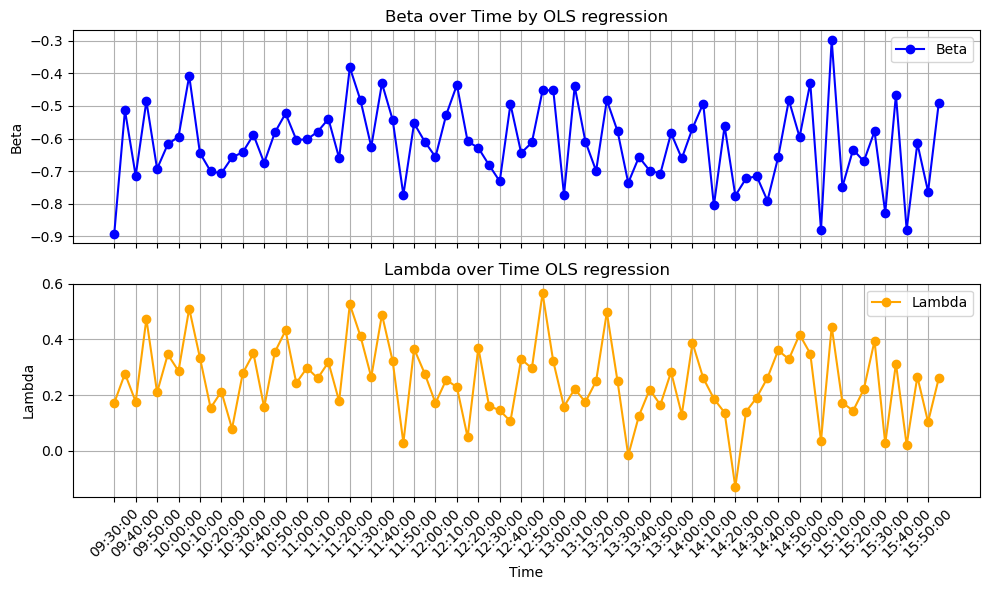

,time,ticker,model,beta,lambda,R-squared,Adj. R-squared,F-statistic,F-pvalue,MSE (Model),MSE (Residual),RMSE (Residual),AIC,BIC
0,09:30:00,AAPL,OW,-0.891765,0.171920,0.882784,0.878521,207.108824,2.495627e-26,25.159333,0.121479,0.348538,43.566181,47.652283
1,09:35:00,AAPL,OW,-0.513290,0.276961,0.416329,0.395105,19.615611,3.712072e-07,11.865386,0.604895,0.777750,135.069145,139.155248
2,09:40:00,AAPL,OW,-0.713922,0.175876,0.686460,0.675059,60.208193,1.406192e-14,19.564119,0.324941,0.570036,99.648722,103.734824
3,09:45:00,AAPL,OW,-0.485380,0.473952,0.634357,0.621061,47.709963,9.639983e-13,18.079173,0.378939,0.615580,108.411424,112.497526
4,09:50:00,AAPL,OW,-0.692862,0.209165,0.677093,0.665351,57.663878,3.159547e-14,19.297155,0.334649,0.578488,101.326685,105.412787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,15:35:00,AAPL,OW,-0.465793,0.313190,0.441699,0.421397,21.756572,1.093664e-07,12.588418,0.578603,0.760660,132.536155,136.622258
74,15:40:00,AAPL,OW,-0.879813,0.020575,0.793167,0.785645,105.457240,1.512061e-19,22.605248,0.214355,0.462984,75.936023,80.022126
75,15:45:00,AAPL,OW,-0.614650,0.265874,0.601119,0.586614,41.442813,1.054876e-11,17.131882,0.413386,0.642951,113.370785,117.456888
76,15:50:00,AAPL,OW,-0.762857,0.102927,0.643969,0.631022,49.740406,4.633658e-13,18.353109,0.368978,0.607435,106.893000,110.979103


In [90]:
intraday_OLS = intraday_for_single_ticker(dic=dfs_ticker, ticker='AAPL', model='OW', annualized=False, ADV_change=False, sigma_change=True)
intraday_OLS 

# Part 3: Bayesian Regression

### use expectation, optimal to use for quadratic loss function

In [55]:
def bayesian_regression(ticker, df, sigma, ADV, model):
    """set up bayesian trace"""
    
    import pymc as pm
    from sklearn.preprocessing import StandardScaler
    
    X = gen_X_by_model(df, sigma, ADV, model)
    y = df['delta_I'][1:]

    scaler = StandardScaler()
    X_stan = scaler.fit_transform(X)
    X1, X2 = X_stan[:,0], X_stan[:,1]
    y_stan = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()
    
    # Create PyMC model
    with pm.Model() as pmmodel:
        # Prior distributions
        param1 = pm.Normal('beta', mu=0, sigma=10)
        param2 = pm.Normal('lambda', mu=0, sigma=10)
        sigma = pm.HalfNormal("sigma", sigma=1)

        # Linear model
        mu = param1 * X1 + param2 * X2

        # Likelihood function
        y_obs = pm.StudentT("y_obs", mu=mu, sigma=sigma, nu=3, observed=y_stan)

        # Sampling
        trace = pm.sample(2000, tune=2000, return_inferencedata=True)
        
    return trace, pmmodel

In [100]:
def bayesian_summary(trace, confidence_level=0.95):
    import arviz as az
    var_names = list(trace.posterior.data_vars.keys())
    res = az.summary(trace, var_names=var_names, hdi_prob=confidence_level)
    #res.to_csv('bayesian_summary.csv')
    return res

In [102]:
def bayesian_distribution(trace,confidence_level=0.95):
    
    import arviz as az
    
    var_names = list(trace.posterior.data_vars.keys())
    az.plot_posterior(trace, var_names=var_names, hdi_prob=confidence_level, 
                      point_estimate="mean", kind="kde")
    plt.suptitle("Improved Posterior Distributions", fontsize=20, y=1.02)  # Adjust overall title
    plt.subplots_adjust(top=0.85, hspace=0.4)  # Adjust spacing between subplots
    plt.savefig(f'Bayesian_HDI.png')
    plt.show()

In [103]:
def bayesian_subplot(trace, confidence_level=0.95):
    
    import arviz as az
    import seaborn as sns
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 1]})

    # Left subplot: Posterior Distributions (KDE)
    var_names = list(trace.posterior.data_vars.keys())
    for var in var_names:
        samples = trace.posterior[var].values.flatten()
        sns.kdeplot(samples, ax=axes[0], label=f"{var} (KDE)", shade=True)
    axes[0].set_xlabel("Parameter Value")
    axes[0].set_ylabel("Density")
    axes[0].set_title("Posterior Distributions (KDE)", fontsize=14)
    axes[0].grid(alpha=0.5)
    axes[0].legend()

    # Right subplot: Forest Plot (HDI)
    az.plot_forest(
        trace,
        var_names=var_names,
        hdi_prob=confidence_level,
        ax=axes[1],  # Specify the subplot for the forest plot
        colors="blue"
    )
    axes[1].set_title("Forest Plot (HDI)", fontsize=14)
    axes[1].set_xlabel("Parameter Value")
    axes[1].grid(alpha=0.5)

    plt.tight_layout()
    plt.savefig(f'Bayesian_KDE.png')
    plt.show()

In [70]:
def main_for_single_ticker_bayesian(dic, ticker, model, confidence_level=0.95):
    
    df = get_ticker_df(dic, ticker)
    df_filter = pre_dropna(df)
    
    ADV = cal_ADV(df_filter)
    sigma = cal_sigma(df_filter, True)
    df_data = gen_elements_df(df_filter)

    trace, model = bayesian_regression(ticker, df_data, sigma, ADV, model)
    bayesian_distribution(trace)
    bayesian_subplot(trace, confidence_level=0.95)
    res = bayesian_summary(trace, confidence_level=0.95)
    
    return 

In [ ]:
def print_adj_R2(y, X1, X2, trace, param_names=('beta','lambda')):

    beta_mean, lambda_mean = 
    
    # Predict
    y_pred = param1_samples[:, None] * X1 + param2_samples[:, None] * X2
    y_pred_mean = np.mean(y_pred, axis=0)
    y_pred_lower = np.percentile(y_pred, 2.5, axis=0)
    y_pred_upper = np.percentile(y_pred, 97.5, axis=0)

    # Visualize
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y)), y, label="True y (Observed)", color="blue")
    plt.plot(range(len(y)), y_pred_mean, label="Predicted y (Mean)", color="red")
    plt.fill_between(range(len(y)), y_pred_lower, y_pred_upper, color="red", alpha=0.2, label="95% Prediction Interval")
    plt.xlabel("Index")
    plt.ylabel("y")
    plt.title("Comparison of True y and Predicted y")
    plt.legend()
    plt.grid()
    plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


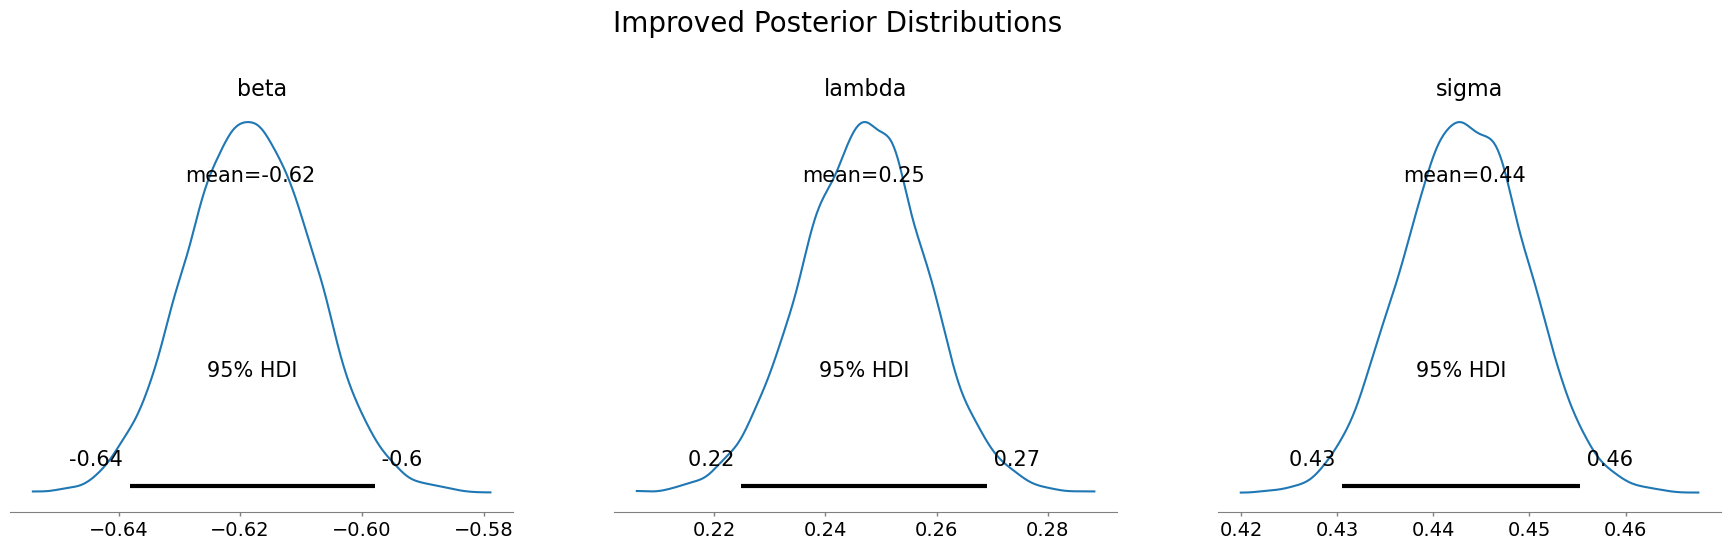

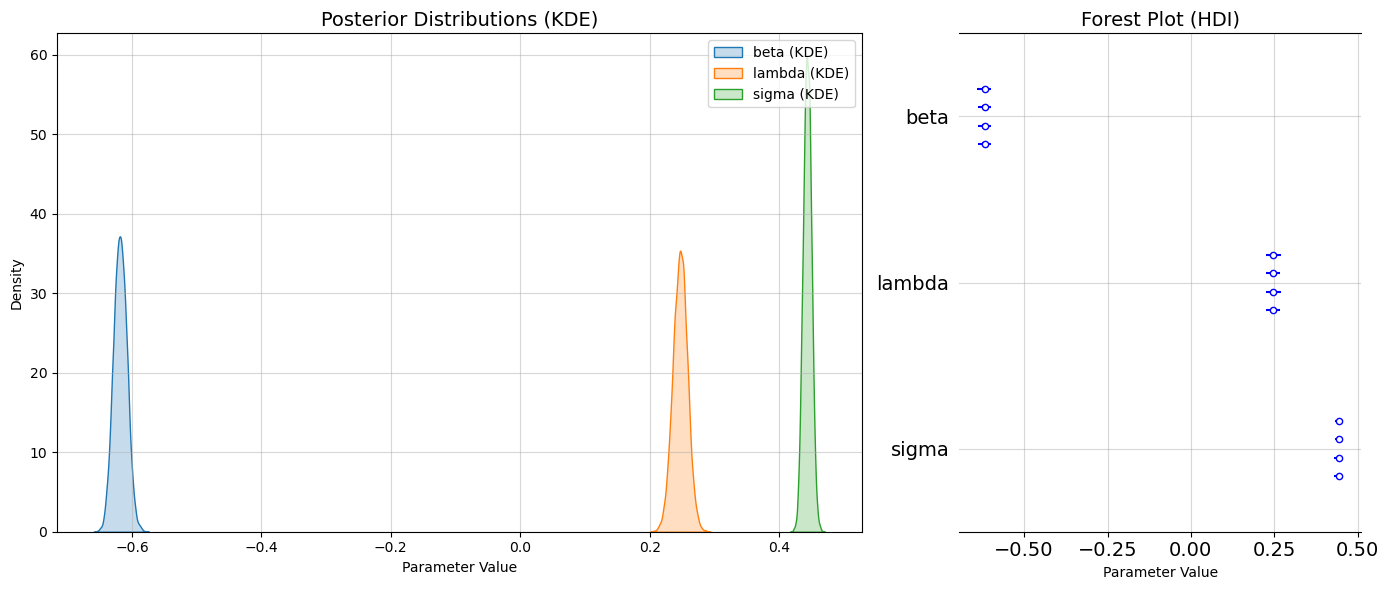

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,-0.618,0.010,-0.638,-0.598,0.0,0.0,8126.0,6553.0,1.0
lambda,0.247,0.011,0.225,0.269,0.0,0.0,8238.0,6551.0,1.0
sigma,0.443,0.006,0.430,0.455,0.0,0.0,9431.0,5993.0,1.0


In [104]:
main_for_single_ticker_bayesian(dfs_ticker, 'AAPL', 'OW', 0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.


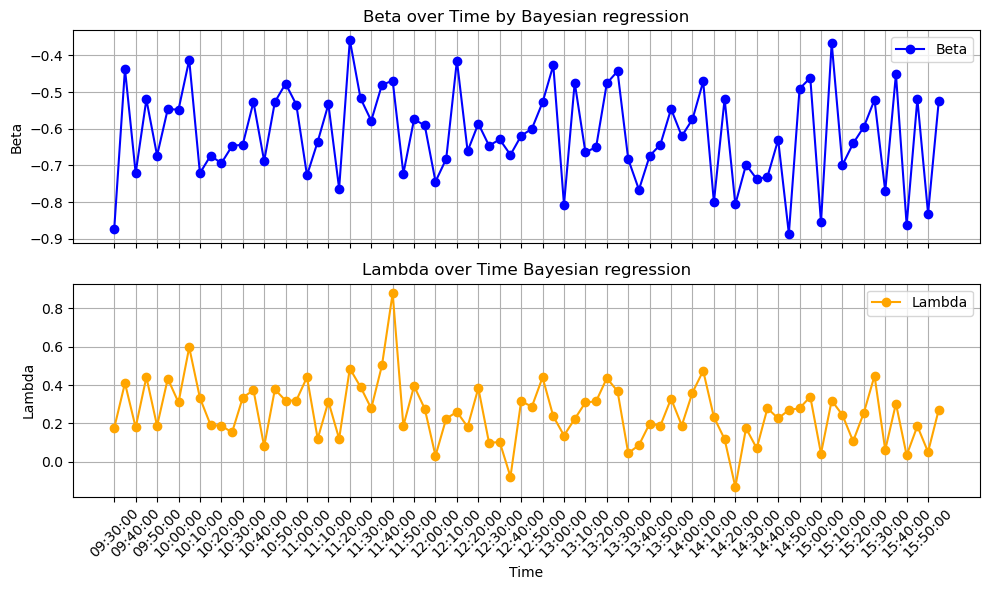

mean,time,beta,lambda,sigma
0,09:30:00,-0.872,0.177,0.275
1,09:35:00,-0.437,0.410,0.613
2,09:40:00,-0.721,0.179,0.442
3,09:45:00,-0.520,0.441,0.530
4,09:50:00,-0.673,0.187,0.463
...,...,...,...,...
73,15:35:00,-0.451,0.303,0.556
74,15:40:00,-0.862,0.034,0.362
75,15:45:00,-0.519,0.186,0.437
76,15:50:00,-0.831,0.051,0.460


In [91]:
intraday_Bayesian = intraday_for_single_ticker(dic=dfs_ticker, ticker='AAPL', model='OW', annualized=False, ADV_change=False, sigma_change=True, mode='Bayesian')
intraday_Bayesian

In [97]:
def plot_compare_intraday(df_ols, df_bayesian, ticker, model):

    df_ols['time'] = pd.to_datetime(df_ols['time'], format='%H:%M:%S')
    df_bayesian['time'] = pd.to_datetime(df_bayesian['time'], format='%H:%M:%S')

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)

    axes[0].plot(df_ols['time'], df_ols['beta'], marker='o', label=f'OLS Beta', color='blue')
    axes[0].plot(df_bayesian['time'], df_bayesian['beta'], marker='o', label=f'Bayesian Beta', color='green')
    axes[0].set_title(f'Beta over Time')
    axes[0].set_ylabel('Beta')
    axes[0].grid(True)
    axes[0].legend()

    axes[1].plot(df_ols['time'], df_ols['lambda'], marker='o', label=f'OLS Lambda', color='orange')
    axes[1].plot(df_bayesian['time'], df_bayesian['lambda'], marker='o', label=f'Bayesian Lambda', color='red')
    axes[1].set_title(f'Lambda over Time')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Lambda')
    axes[1].grid(True)
    axes[1].legend()

    xticks = df_ols['time'][::2] 
    axes[-1].set_xticks(xticks)
    axes[-1].set_xticklabels(xticks.dt.strftime('%H:%M:%S'), rotation=45)

    plt.tight_layout()
    
    plt.savefig(f'{ticker} {model} intraday.png')
    
    plt.show()

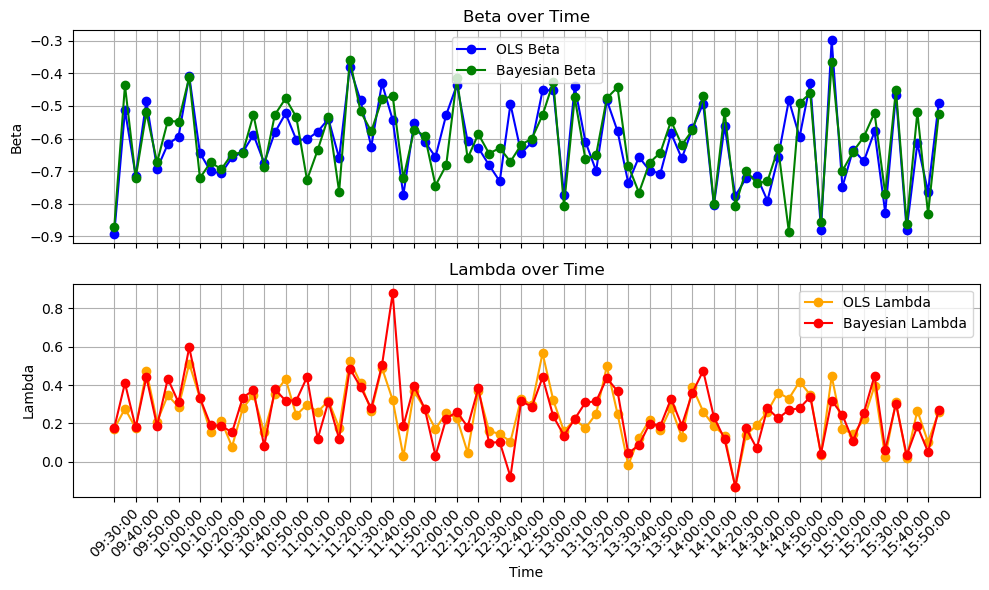

In [98]:
plot_compare_intraday(intraday_OLS, intraday_Bayesian, 'AAPL', 'OW')